# Capítulo 2 - Pré-processamento dos dados

## Bibliotecas básicas e outras inicializações

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Carregamento dos dados

In [2]:
dados = pd.read_csv('./datasets/mammographic_masses.data', 
                    names=['bi_rads', 'idade', 'forma_da_massa', 'contorno_da_massa', 'densidade_da_massa', 'severidade'], 
                    na_values='?')
dados.head()

,bi_rads,idade,forma_da_massa,contorno_da_massa,densidade_da_massa,severidade
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [3]:
print(f'Linhas: {dados.shape[0]} | Colunas: {dados.shape[1]}')

Linhas: 961 | Colunas: 6


In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bi_rads             959 non-null    float64
 1   idade               956 non-null    float64
 2   forma_da_massa      930 non-null    float64
 3   contorno_da_massa   913 non-null    float64
 4   densidade_da_massa  885 non-null    float64
 5   severidade          961 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.2 KB


### Dicionário dos dados

**bi_rads**: sistema de clasificação adotado para estimar qual a chance de determinada imagem da mamografia ser câncer.{0-6}(float)

**idade**: idade do paciente em anos.(float)

**forma_da_massa**: {redonda=1, ovular=2, lobular=3, irregular=4}(float)

**contorno_da_massa**: {circunscrita=1, microlobulada=2, obscura=3, mal definida=4, especulada=5}(float)

**densidade_da_massa**: {alta=1, iso=2, baixa=3, gordurosa=4}(float)

**severidade**: {benigno=0, maligno=1}(inteiro)

## Limpeza da base

### Valores ausentes

#### Ignorar o objeto

In [5]:
dados_copy = dados.copy()
print(f'Antes: {dados_copy.shape}')
dados_copy.dropna(inplace=True)
print(f'Depois: {dados_copy.shape}')

Antes: (961, 6)
Depois: (830, 6)


In [6]:
print(f'Foram removidos {round((961-830)*100/961, 2)}% da base')

Foram removidos 13.63% da base


#### Imputar manualmente os valores ausentes

In [7]:
dados_copy = dados.copy()
print('Total de dados ausentes na coluna densidade_da_massa: ', dados_copy['densidade_da_massa'].isnull().sum())
dados_copy['densidade_da_massa'].fillna(1, inplace=True)
print('Total de dados ausentes na coluna densidade_da_massa: ', dados_copy['densidade_da_massa'].isnull().sum())

Total de dados ausentes na coluna densidade_da_massa:  76
Total de dados ausentes na coluna densidade_da_massa:  0


#### Imputar de acordo com a última observação (last observation carried forward)

In [8]:
dados_copy = dados.copy()
print('Total de dados ausentes na coluna contorno_da_massa: ', dados_copy['contorno_da_massa'].isnull().sum())
dados_copy['contorno_da_massa'].fillna(method='ffill', inplace=True)
print('Total de dados ausentes na coluna contorno_da_massa: ', dados_copy['contorno_da_massa'].isnull().sum())

Total de dados ausentes na coluna contorno_da_massa:  48
Total de dados ausentes na coluna contorno_da_massa:  0


#### Imputação do tipo hot-deck

In [9]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='distance')
dados_copy = dados.copy()

print('Total de dados ausentes na coluna idade: ', dados_copy['idade'].isnull().sum())
dados_copy['idade'] = imputer.fit_transform(dados_copy[['idade']])
print('Total de dados ausentes na coluna idade: ', dados_copy['idade'].isnull().sum())

Total de dados ausentes na coluna idade:  5
Total de dados ausentes na coluna idade:  0


#### Imputação com média, mediana ou moda

In [10]:
dados_copy = dados.copy()
dados_copy['idade'] = dados_copy['idade'].fillna(dados_copy['idade'].mean())
dados_copy['contorno_da_massa'] = dados_copy['contorno_da_massa'].fillna(dados_copy['contorno_da_massa'].median())

#### Imputação com média, mediana ou moda de objetos da mesma classe

In [11]:
dados_copy = dados.copy()
dados_copy['idade'] = dados_copy['idade'].fillna(dados_copy[dados_copy['severidade']==0]['idade'].mean())
dados_copy['idade'] = dados_copy['idade'].fillna(dados_copy[dados_copy['severidade']==1]['idade'].mean())

#### Usando modelos preditivos

In [12]:
from sklearn.tree import DecisionTreeClassifier

dados_copy = dados.copy()

test = dados_copy[dados_copy['idade'].isnull()]
test.drop(['idade'], 1, inplace=True)
dados_copy.dropna(inplace=True)

X = dados_copy.drop(['idade'], 1)
y = dados_copy['idade']


model = DecisionTreeClassifier()
model.fit(X, y)
nova_idade = model.predict(test)
test['idade'] = nova_idade

dados_copy = dados.copy()
dados_copy['idade'].fillna(value=test['idade'], inplace=True)

#### Tratando valores ausentes na base original

In [13]:
for col in dados.iloc[:, 0:5].columns:
    dados[col].fillna(method='ffill', inplace=True)
    
print(f'Valores nulos na base: \n{dados.isnull().sum()}')

Valores nulos na base: 
bi_rads               0
idade                 0
forma_da_massa        0
contorno_da_massa     0
densidade_da_massa    0
severidade            0
dtype: int64


### Dados ruidosos

#### Dados discrepantes

In [14]:
dados['bi_rads'].value_counts()

4.0     549
5.0     345
3.0      36
2.0      14
6.0      11
0.0       5
55.0      1
Name: bi_rads, dtype: int64

In [15]:
dados['bi_rads'][dados[dados['bi_rads']==55.0].index[0]] = 5.0
dados['bi_rads'].value_counts()

4.0    549
5.0    346
3.0     36
2.0     14
6.0     11
0.0      5
Name: bi_rads, dtype: int64

#### Encaixotamento (binning) com QCut:  discretize a variável em intervalos de tamanhos aproximadamente iguais

In [16]:
dados_copy = dados.copy()

In [17]:
dados_copy['idade_bins'] = pd.qcut(dados_copy['idade'].sort_values(), q=5)
dados_copy['idade_bins'].value_counts()

(17.999, 43.0]    208
(43.0, 53.0]      196
(53.0, 60.0]      191
(67.0, 96.0]      189
(60.0, 67.0]      177
Name: idade_bins, dtype: int64

#### Encaixotamento (binning) com Cut: segmenta e classifica os valores dos dados em compartimentos

In [18]:
dados_copy['forma_da_massa_bins'] = pd.cut(dados_copy['forma_da_massa'].sort_values(), bins=3, right=True)
dados_copy['forma_da_massa_bins'].value_counts()

(0.997, 2.0]    455
(3.0, 4.0]      409
(2.0, 3.0]       97
Name: forma_da_massa_bins, dtype: int64

#### Pontuação de anomalias

In [19]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=3)
dados_copy['is_outlier'] = clf.fit_predict(dados_copy.drop(['forma_da_massa_bins', 'idade_bins'], axis=1))
dados_copy.head()

,bi_rads,idade,forma_da_massa,contorno_da_massa,densidade_da_massa,severidade,idade_bins,forma_da_massa_bins,is_outlier
0,5.0,67.0,3.0,5.0,3.0,1,"(60.0, 67.0]","(2.0, 3.0]",-1
1,4.0,43.0,1.0,1.0,3.0,1,"(17.999, 43.0]","(0.997, 2.0]",-1
2,5.0,58.0,4.0,5.0,3.0,1,"(53.0, 60.0]","(3.0, 4.0]",1
3,4.0,28.0,1.0,1.0,3.0,0,"(17.999, 43.0]","(0.997, 2.0]",1
4,5.0,74.0,1.0,5.0,3.0,1,"(67.0, 96.0]","(0.997, 2.0]",1


#### Agrupamento

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(dados_copy.drop(['idade_bins', 'forma_da_massa_bins', 'is_outlier'], axis=1))
centroides = kmeans.cluster_centers_
print(centroides)

[[ 4.11520737 43.68663594  2.30414747  2.29953917  2.82488479  0.29032258]
 [ 4.39516129 66.48790323  3.00806452  3.21370968  2.93951613  0.63306452]
 [ 4.29824561 55.7122807   2.79298246  2.92280702  2.90526316  0.44561404]
 [ 3.99056604 29.5         1.94339623  1.60377358  2.91509434  0.11320755]
 [ 4.73333333 78.78095238  3.37142857  3.58095238  2.88571429  0.81904762]]


In [21]:
dados_copy['agrupamento'] = kmeans.labels_

for label in dados_copy['agrupamento']:
    if label == 0:
        dados_copy['centroide'] = centroides[0].max()
    elif label == 1:
        dados_copy['centroide'] = centroides[1].max()
    elif label == 2:
        dados_copy['centroide'] = centroides[2].max()
    elif label == 3:
        dados_copy['centroide'] = centroides[3].max()
    else:
        dados_copy['centroide'] = centroides[4].max()
        
dados_copy.sample()

,bi_rads,idade,forma_da_massa,contorno_da_massa,densidade_da_massa,severidade,idade_bins,forma_da_massa_bins,is_outlier,agrupamento,centroide
770,4.0,54.0,1.0,1.0,3.0,0,"(53.0, 60.0]","(0.997, 2.0]",1,2,66.487903


### Redução dos dados

#### Compressão de atributos

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dados)

PCA(n_components=2)

In [23]:
print('Primeiro componente: ', pca.components_.T[:,0])
print('Segundo componente: ', pca.components_.T[:,1])

Primeiro componente:  [0.01386695 0.99846532 0.03040462 0.04165048 0.00109936 0.01463895]
Segundo componente:  [-0.15772891  0.05468933 -0.56919436 -0.79177609 -0.02105915 -0.14420673]


In [24]:
print('%Variância explicada por cada componente: ', pca.explained_variance_ratio_)

%Variância explicada por cada componente:  [0.98011949 0.01388387]


In [25]:
print('Perda da variação com a redução: ', round(1 - pca.explained_variance_ratio_.sum(), 2))

Perda da variação com a redução:  0.01


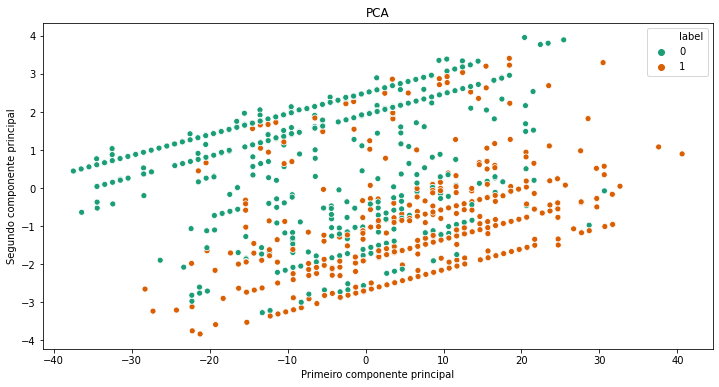

In [26]:
pca_df = pd.DataFrame(pca.fit_transform(dados), columns=['Primeiro componente principal', 'Segundo componente principal'])
pca_df['label'] = dados['severidade']

plt.figure(figsize=(12, 6))
sns.scatterplot(data=pca_df, x='Primeiro componente principal', y='Segundo componente principal', hue='label', palette='Dark2')
plt.title('PCA')
plt.show()

#### Redução do número de dados

 Amostragem aleatória simples sem repetição

In [27]:
amostra = dados.sample(100)
amostra.head()

,bi_rads,idade,forma_da_massa,contorno_da_massa,densidade_da_massa,severidade
823,4.0,74.0,1.0,1.0,1.0,1
94,5.0,60.0,1.0,1.0,3.0,0
885,4.0,65.0,2.0,4.0,3.0,1
777,4.0,33.0,1.0,1.0,3.0,0
607,4.0,55.0,1.0,1.0,3.0,0


Amostragem aleatória simples com repetição

In [28]:
amostra = dados.sample(100, replace=True)
print('Ítens duplicados: ', amostra.duplicated().sum())

Ítens duplicados:  7


Amostragem Aleatória Estratificada

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dados.iloc[:, 0:5], dados['severidade'], stratify=dados['severidade'], 
                                                    test_size=0.20)

print('%Base original:\n')
print(dados['severidade'].value_counts(normalize=True))
print('\n%Dados de treino:\n')
print(y_train.value_counts(normalize=True))
print('\n%Dados de teste:\n')
print(y_test.value_counts(normalize=True))

%Base original:

0    0.536941
1    0.463059
Name: severidade, dtype: float64

%Dados de treino:

0    0.536458
1    0.463542
Name: severidade, dtype: float64

%Dados de teste:

0    0.53886
1    0.46114
Name: severidade, dtype: float64


Amostragem Sistemática

In [30]:
indices = np.arange(0, 961, 10)
amostra = dados.loc[indices]
amostra.head()

,bi_rads,idade,forma_da_massa,contorno_da_massa,densidade_da_massa,severidade
0,5.0,67.0,3.0,5.0,3.0,1
10,5.0,76.0,1.0,4.0,3.0,1
20,4.0,66.0,1.0,1.0,1.0,1
30,4.0,46.0,1.0,5.0,2.0,0
40,4.0,59.0,2.0,1.0,2.0,0


Amostragem por grupo

In [31]:
grupo = dados.groupby('severidade').apply(pd.DataFrame.sample, frac=.5)
amostra_1 = grupo[grupo['severidade']==0]
amostra_2 = grupo[grupo['severidade']==1]

amostra_1.reset_index(drop=True, inplace=True)
amostra_2.reset_index(drop=True, inplace=True)

amostra = pd.concat([amostra_1, amostra_2])
amostra.sample(5)

,bi_rads,idade,forma_da_massa,contorno_da_massa,densidade_da_massa,severidade
168,6.0,80.0,4.0,5.0,3.0,1
229,3.0,53.0,4.0,3.0,3.0,0
45,5.0,55.0,2.0,4.0,3.0,1
158,4.0,57.0,2.0,4.0,3.0,0
13,4.0,50.0,4.0,4.0,3.0,1


### Padronização dos dados

In [32]:
for col in dados.columns:
    dados[col] = dados[col].astype(int)
    
dados.dtypes

bi_rads               int64
idade                 int64
forma_da_massa        int64
contorno_da_massa     int64
densidade_da_massa    int64
severidade            int64
dtype: object

### Normalização

#### Min-Max

In [33]:
dados_copy = dados.copy()

vmin = dados_copy['idade'].min()
vmax = dados_copy['idade'].max()
dados_copy['min_max'] = dados_copy['idade'].apply(lambda x : (x - vmin) / (vmax - vmin) * (1-0) + 0)

#### Z-score

In [34]:
std = dados_copy['idade'].std()
media = dados_copy['idade'].mean()
dados_copy['z_score'] = dados_copy['idade'].apply(lambda x : (x-media)/std)

#### Por escala decimal

In [35]:
j = len(str(abs(dados_copy['idade'].max())))
dados_copy['escalonamento_decimal'] = dados_copy['idade'].apply(lambda x : x/10**j)

#### Interquartil

In [36]:
Q1 = dados_copy['idade'].describe()['25%']
Q2 = dados_copy['idade'].describe()['50%']
Q3 = dados_copy['idade'].describe()['75%']
IQR = Q3-Q1
dados_copy['interquartil'] = dados_copy['idade'].apply(lambda x : (x-Q2)/IQR)

#### Resultado

In [37]:
dados_copy.drop(['bi_rads', 'forma_da_massa', 'contorno_da_massa', 'densidade_da_massa', 'severidade'], axis=1).head()

,idade,min_max,z_score,escalonamento_decimal,interquartil
0,67,0.628205,0.799154,0.67,0.476190
1,43,0.320513,-0.855248,0.43,-0.666667
2,58,0.512821,0.178754,0.58,0.047619
3,28,0.128205,-1.889250,0.28,-1.380952
4,74,0.717949,1.281688,0.74,0.809524


### Discretização